## Authorship matrix and contribution statement for IBL behavioral standardization platform paper
#### https://doi.org/10.1101/2020.01.17.909838
Anne Urai, CSHL, 2020

See https://github.com/int-brain-lab/paper-behavior/blob/master/authorship/Authorship%20and%20contribution%20for%20IBL%20behavior%20paper.ipynb for a more in-depth discussion and analysis of author contribution logging

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
sns.set()

df = pd.read_csv('csv/Behavior paper contribution statement - v2 (2020) - full_descriptions.csv')
df = df.rename(columns={'credit_proposal_v2':'credit'})
df = df[['first_name', 'last_name', 'credit']]

In [2]:
new_df = []
for aidx, author in df.groupby(['last_name', 'first_name']):

    # parse author for initials - for long-form contribution statement
    words_last = author.last_name.item().split()
    letters_last = [word[0] for word in words_last]
    words_first = author.first_name.item().split()
    letters_first = [word[0] for word in words_first]
    initials = '.'.join(letters_first + letters_last) + '.'
         
    # tease apart the credit assignment column
    statement = author['credit'].item()
    if not isinstance(statement, str):
        continue
    statement_split = statement.split("[")
    for s in statement_split:
        cat_split = s.split("]")
        if len(cat_split) > 1:
            credit_category = cat_split[0]
            task_split = cat_split[1].split(")")
            for t in task_split:
                contrib_split = t.split("(")
                if len(contrib_split) == 2:
                    # print(contrib_split)
                    task = contrib_split[0]
                    if '{' in task:
                        final_split = task.split("{")
                        task = final_split[0]
                        specific = final_split[1].replace('} ', ']')
                        specific = ' [' + specific
                    else:
                        specific = ''
                    contribution = contrib_split[1]
                    
                    # add these
                    new_df.append({'last_name':author.last_name.item(),
                                  'first_name':author.first_name.item(),
                                  'author_initials':initials,
                                  'credit_category': credit_category.lower().replace('–', '-'),
                                  'task': task.lower().replace('\n', '').strip(),
                                  'contribution': contribution.lower(),
                                  'specific': specific})
                    
new_df = pd.DataFrame(new_df)

# add some vars
new_df['credit_task'] = new_df.credit_category.str.upper() + ': ' + new_df.task
new_df['contribution_level'] = new_df.contribution.map({'lead':3, 'equal':2, 'support':1})
new_df['author'] = new_df.last_name + ', ' + new_df.first_name

In [3]:
sorted(new_df.credit_task.unique())

['CONCEPTUALIZATION: defined composition and scope of the paper',
 'DATA CURATION: curated data and metadata',
 'FORMAL ANALYSIS: analyzed data',
 'FUNDING ACQUISITION: acquired funding',
 'INVESTIGATION: built and maintained rigs, performed surgeries, collected behavioral data',
 'METHODOLOGY: built, designed and tested rig assembly',
 'METHODOLOGY: design and delivery of rig components',
 'METHODOLOGY: designed and delivered rig components',
 'METHODOLOGY: developed final behavioral task',
 'METHODOLOGY: developed protocols for surgery, husbandry and animal training',
 'METHODOLOGY: piloted candidate behavioral tasks',
 'METHODOLOGY: standardized licenses and experimental protocols across institutions',
 'PROJECT ADMINISTRATION: managed and coordinated research outputs',
 'RESOURCES: hosted the research',
 'SOFTWARE: developed data acquisition software and infrastructure',
 'SUPERVISION: managed and coordinated team',
 'SUPERVISION: supervised local laboratory research',
 'VALIDATION

In [4]:
new_df.contribution.unique()
assert(all(new_df.groupby(['task'])['credit_category'].nunique() == 1))

In [5]:
# ensure initials are unique
new_df.groupby(['author_initials'])['author'].unique()

author_initials
A.E.U.                  [Urai, Anne E.]
A.K.                     [Khanal, Anup]
A.K.C.             [Churchand, Anne K.]
A.M.Z.              [Zador, Anthony M.]
A.P.           [Pan-Vazquez, Alejandro]
C.J.W.           [Wilson, Christian J.]
C.R.                 [Rossant, Cyrille]
C.S.K.       [Krasniak, Christopher S.]
D.E.A.              [Angelaki, Dora E.]
E.E.D.                [DeWitt, Eric E.]
F.C.                  [Cazettes, Fanny]
F.H.                          [Hu, Fei]
G.A.C.             [Chapuis, Gaelle A.]
G.T.M.               [Meijer, Guido T.]
H.F.                  [Forrest, Hamish]
H.M.B.               [Bayer, Hannah M.]
H.M.V.           [Vergara, Hernando M.]
I.B.W.               [Witten, Ilana B.]
I.C.L.            [Laranjeira, Inês C.]
J.I.S.             [Sanders, Joshua I.]
J.P.N.                [Noel, Jean Paul]
K.Z.S.             [Socha, Karolina Z.]
L.E.W.                [Wool, Lauren E.]
L.M.H.              [Haetzel, Laura M.]
M.C.                [Car

In [6]:
# sort categories in the Credit order (instead of alphabetical)
credit_category_order = [x.lower() for x in ['Conceptualization', 'Methodology', 'Software', 
                         'Validation', 'Formal Analysis', 'Investigation', 'Resources', 
                         'Data curation', 'Writing – Original Draft', 'Writing – Review & Editing',
                         'Visualization', 'Supervision',
                         'Project Administration', 'Funding acquisition']]
order_dict = { credit_category_order[i] : i for i in range(0, len(credit_category_order) ) }
new_df['category_order'] = new_df['credit_category'].map(order_dict)
new_df = new_df.sort_values(by=['last_name', 'category_order'])

In [7]:
#matrix = new_df.pivot("credit_task", "author", "contribution_level").fillna(0)
matrix = new_df.pivot_table(values='contribution_level', index=['category_order', 'credit_task'],
                    columns=['author'], fill_value=0)
matrix.to_csv('contributions_matrixform.csv')
matrix.index = [col[1] for col in matrix.index] # remove the sorting column from the index

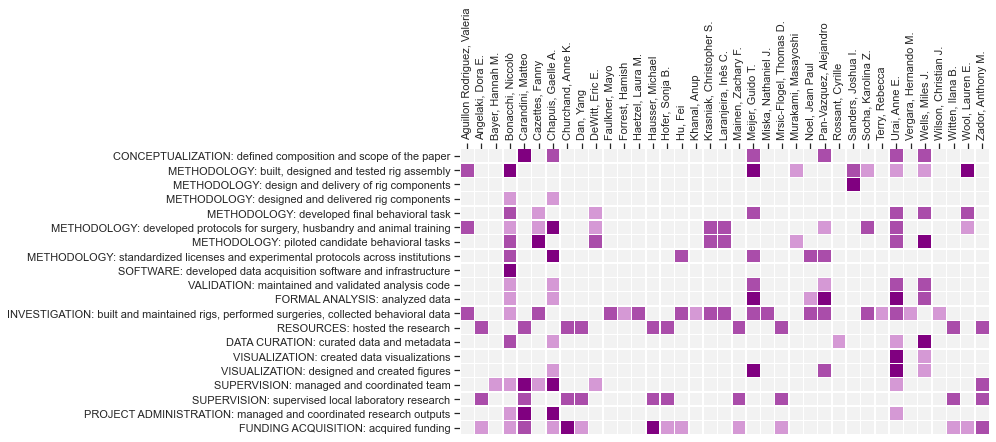

In [8]:
cmap = sns.light_palette("purple", n_colors=4)
cmap[0] = (0.95, 0.95, 0.95)

fig, ax = plt.subplots(1,1,figsize=(14,9))
sns.heatmap(matrix, annot=False, yticklabels=True, cmap=cmap, 
            linewidths=.5, ax=ax, cbar=False, square=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis="x", bottom=False, top=True, 
               labelbottom=False, labeltop=True, rotation=90)
ax.tick_params(axis="y", left=True, right=False)
plt.tight_layout()
fig.savefig('contributions.png', dpi=400)
fig.savefig('contributions.pdf')

In [9]:
## WRITE THIS OUT FOR THE CONTRIBUTION STATEMENT IN THE PAPER
# also here, order the tasks by credit category

new_df['task'] = new_df['credit_task'] + ' (' + new_df['contribution'] + ')' + new_df['specific']

if os.path.isfile('contributions_text.txt'):
    os.remove('contributions_text.txt')
f = open("contributions_text.txt", "a")

for author, tmpdf in new_df.groupby(['author']):
    txt = tmpdf['first_name'].unique()[0] + ' ' + tmpdf['last_name'].unique()[0] + \
        ': ' + '; '.join(tmpdf.task.values)
    f.write(txt + "\n")
f.close()